# MATH Sensitivity analyses

In [ ]:
# load core libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# transformers for detection, sklearn metrics/calibration
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.calibration import calibration_curve

import ast

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", DEVICE)

/home/cpsc477_kl938/evaluation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
def build_aligned_longform_from_naturalproofs(
    input_path: str = "LLM_generated_naturalproofs.csv",
) -> pd.DataFrame:
    """
    Reads the CSV, aligns generated answers per doc_id,
    and groups all human variants together.
    """
    # load the raw csv
    df = pd.read_csv(input_path, index_col=False)

    # parse string/list ID into tuple, extract first element as doc_id
    def parse_id(x):
        if isinstance(x, str):
            tup = tuple(ast.literal_eval(x))
        else:
            tup = tuple(x) if isinstance(x, (list, tuple)) else (x,)
        return tup

    df['ID_parsed'] = df['ID'].apply(parse_id)
    df['doc_id']    = df['ID_parsed'].apply(lambda t: t[0])

    # rename columns for clarity
    df = df.rename(columns={
        'Problem':       'prompt',
        'zeroshot':      'ans_base',
        'fewshot':       'ans_few',
        'fewshot2':      'ans_hard',
        'ground_truth':  'ans_human'
    })

    # drop exact duplicate rows
    df = df.drop_duplicates(
        subset=['doc_id','prompt','ans_base','ans_few','ans_hard','ans_human'],
        keep='first'
    )

    # group by generated answers to collect all human variants
    grouped = (
        df
        .groupby(['doc_id','prompt','ans_base','ans_few','ans_hard'], dropna=False)
        .agg({'ans_human': list})
        .reset_index()
    )

    # expand into long form: 3 generated + each human answer
    rows = []
    for _, r in grouped.iterrows():
        doc    = r['doc_id']
        prompt = r['prompt']
        # generated variants (label=0)
        rows.append({'doc_id': doc, 'prompt': prompt, 'variant': 'baseline',            'text': r['ans_base'], 'label': 0})
        rows.append({'doc_id': doc, 'prompt': prompt, 'variant': 'few_shot',            'text': r['ans_few'],  'label': 0})
        rows.append({'doc_id': doc, 'prompt': prompt, 'variant': 'prompt_engineering', 'text': r['ans_hard'], 'label': 0})
        # human variants (label=1)
        for human_text in r['ans_human']:
            rows.append({'doc_id': doc, 'prompt': prompt, 'variant': 'human', 'text': human_text, 'label': 1})

    long_df = pd.DataFrame(rows)
    print(f"🎯 Expanded to {len(long_df)} rows ({len(grouped)} docs × (3 generated + N human variants))")
    return long_df

if __name__ == '__main__':
    # generate and save aligned long-form CSV
    df_long = build_aligned_longform_from_naturalproofs()
    df_long.to_csv("aligned_naturalproofs_longform.csv", index=False)

✅ 4996 questions aligned across baseline, few_shot, and harder variants
🎯 Expanded to 19984 rows (4996 questions × 4 variants)


In [ ]:
import re

def extract_answer(text: str) -> str | None:
    """
    Extract a single, verifiable answer from an LLM-generated solution.

    1) Look for all \\boxed{...} occurrences. If found, use the last one.
    2) If none, fall back to the first simple numeric pattern in the text.
    3) Normalize TeX fractions and strip extra markup.
    4) Return the string if it matches int/decimal/fraction, else None.
    """
    if not isinstance(text, str):
        return None
    
    # 1) find all \boxed{...}
    #    capture content inside the braces (non-greedy)
    boxes = re.findall(r'\\boxed\{([^}]+)\}', text)
    
    if boxes:
        raw = boxes[-1]
    else:
        # 2) fallback: first appearance of a simple number or fraction
        m = re.search(r'-?\d+(?:\.\d+)?(?:/\d+)?', text)
        if not m:
            return None
        raw = m.group(0)
    
    # 3) clean up raw answer:
    ans = raw.strip()               # trim whitespace
    ans = ans.strip('$')            # drop surrounding dollar signs
    
    # handle \frac{a}{b} → a/b
    frac_match = re.fullmatch(r'\\frac\{(-?\d+)\}\{(-?\d+)\}', ans)
    if frac_match:
        ans = f"{frac_match.group(1)}/{frac_match.group(2)}"
    
    # remove any remaining TeX commands, e.g. \, \; etc.
    ans = re.sub(r'\\[a-zA-Z]+', '', ans).strip()
    
    # 4) validate final answer is one of: -?digits(.digits)? or -?digits/​digits
    if re.fullmatch(r'-?\d+(?:\.\d+)?(?:/\d+)?', ans):
        return ans
    
    return None

# ---- Example of applying to your dataframe ----

# Assuming your exploded DataFrame is called df_long and has a 'text' column:
df_long['boxed_answer'] = df_long['text'].apply(extract_answer)

# You can then quickly see how many you got:
total = len(df_long)
no_box = df_long['boxed_answer'].isna().sum()
multi_box = (df_long['text'].str.count(r'\\boxed\{') > 1).sum()

df_long.to_csv("results/test_dfp_longform.csv", index=False)

print(f"Total rows:            {total}")
print(f"Unextracted answers:  {no_box} ({no_box/total:.1%})")
print(f"Multi-box cases:      {multi_box} ({multi_box/total:.1%})")

Total rows:            19984
Unextracted answers:  6623 (33.1%)
Multi-box cases:      4265 (21.3%)


In [4]:
df_long

,id,prompt,variant,type,level,text,label,boxed_answer
0,0,How many vertical asymptotes does the graph of...,baseline,Algebra,Level 3,The graph of a rational function $y=\frac{f(x)...,0,2
1,0,How many vertical asymptotes does the graph of...,few_shot,Algebra,Level 3,The denominator of the fraction is $x^2+x-6$. ...,0,2
2,0,How many vertical asymptotes does the graph of...,prompt_engineering,Algebra,Level 3,The graph of a rational function (a function t...,0,2
3,0,How many vertical asymptotes does the graph of...,human,Algebra,Level 3,The denominator of the rational function facto...,1,2
4,1,What is the positive difference between $120\%...,baseline,Algebra,Level 1,"To find $120\%$ of 30, we multiply 30 by 1.2 (...",0,10
...,...,...,...,...,...,...,...,...
19979,4995,Find the smallest positive integer solution to...,human,Precalculus,Level 5,"By the tangent addition formula,\n\begin{align...",1,159
19980,4996,The matrix for reflecting over a certain line ...,baseline,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None
19981,4996,The matrix for reflecting over a certain line ...,few_shot,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None
19982,4996,The matrix for reflecting over a certain line ...,prompt_engineering,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None


In [5]:
df_long = df_long.dropna(subset=["text"]).reset_index(drop=True)

test_dfp = df_long.copy()
#test_dfp.head(20)

In [6]:
test_dfp

,id,prompt,variant,type,level,text,label,boxed_answer
0,0,How many vertical asymptotes does the graph of...,baseline,Algebra,Level 3,The graph of a rational function $y=\frac{f(x)...,0,2
1,0,How many vertical asymptotes does the graph of...,few_shot,Algebra,Level 3,The denominator of the fraction is $x^2+x-6$. ...,0,2
2,0,How many vertical asymptotes does the graph of...,prompt_engineering,Algebra,Level 3,The graph of a rational function (a function t...,0,2
3,0,How many vertical asymptotes does the graph of...,human,Algebra,Level 3,The denominator of the rational function facto...,1,2
4,1,What is the positive difference between $120\%...,baseline,Algebra,Level 1,"To find $120\%$ of 30, we multiply 30 by 1.2 (...",0,10
...,...,...,...,...,...,...,...,...
19978,4995,Find the smallest positive integer solution to...,human,Precalculus,Level 5,"By the tangent addition formula,\n\begin{align...",1,159
19979,4996,The matrix for reflecting over a certain line ...,baseline,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None
19980,4996,The matrix for reflecting over a certain line ...,few_shot,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None
19981,4996,The matrix for reflecting over a certain line ...,prompt_engineering,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None


In [7]:
len(test_dfp)

19983

In [17]:
test_dfp

,id,prompt,variant,type,level,text,label
0,0,How many vertical asymptotes does the graph of...,baseline,Algebra,Level 3,The graph of a rational function $y=\frac{f(x)...,0
1,0,How many vertical asymptotes does the graph of...,few_shot,Algebra,Level 3,The denominator of the fraction is $x^2+x-6$. ...,0
2,0,How many vertical asymptotes does the graph of...,harder,Algebra,Level 3,The graph of a rational function (a function t...,0
3,0,How many vertical asymptotes does the graph of...,human,Algebra,Level 3,The denominator of the rational function facto...,1
4,1,What is the positive difference between $120\%...,baseline,Algebra,Level 1,"To find $120\%$ of 30, we multiply 30 by 1.2 (...",0
...,...,...,...,...,...,...,...
19978,4995,Find the smallest positive integer solution to...,human,Precalculus,Level 5,"By the tangent addition formula,\n\begin{align...",1
19979,4996,The matrix for reflecting over a certain line ...,baseline,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0
19980,4996,The matrix for reflecting over a certain line ...,few_shot,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0
19981,4996,The matrix for reflecting over a certain line ...,harder,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0


In [ ]:
#load test labels and detector outputs

# load the long-form labeled test set
# test_dfp = pd.read_csv("results/test_dfp_longform_labeled.csv")
print(f"🔎 Loaded test_dfp with {len(test_dfp)} rows")

# load detector predictions/probs/logits
data = np.load("naturalproofs_detector_inference.npz")
MODEL_ORDER = ["Baseline", "SFT-LoRA", "RL-Detector"]

# check that each expected array is present
for m in MODEL_ORDER:
    for suffix in ("preds", "probs", "logits"):
        key = f"{m}_{suffix}"
        if key not in data:
            raise KeyError(f"missing key in detector_inference.npz: {key}")
        print(f" {key:20s} → shape = {data[key].shape}")

# verify that array lengths match number of test rows
L = len(test_dfp)
for m in MODEL_ORDER:
    if data[f"{m}_preds"].shape[0] != L:
        raise ValueError(f"length mismatch for {m}: {data[f'{m}_preds'].shape[0]} vs {L}")

# build dicts for preds, probs, logits
preds_dict  = {m: data[f"{m}_preds"]  for m in MODEL_ORDER}
probs_dict  = {m: data[f"{m}_probs"]  for m in MODEL_ORDER}
logits_dict = {m: data[f"{m}_logits"] for m in MODEL_ORDER}

print("✅ Everything loaded and aligned. Ready for analysis!")

🔎 Loaded test_dfp with 19983 rows
 Baseline_preds       → shape = (19983,)
 Baseline_probs       → shape = (19983,)
 Baseline_logits      → shape = (19983, 2)
 SFT‑LoRA_preds       → shape = (19983,)
 SFT‑LoRA_probs       → shape = (19983,)
 SFT‑LoRA_logits      → shape = (19983, 2)
 RL‑Detector_preds    → shape = (19983,)
 RL‑Detector_probs    → shape = (19983,)
 RL‑Detector_logits   → shape = (19983, 2)
✅ Everything loaded and aligned. Ready for analysis!


In [8]:
test_dfp

,id,prompt,variant,type,level,text,label,boxed_answer
0,0,How many vertical asymptotes does the graph of...,baseline,Algebra,Level 3,The graph of a rational function $y=\frac{f(x)...,0,2
1,0,How many vertical asymptotes does the graph of...,few_shot,Algebra,Level 3,The denominator of the fraction is $x^2+x-6$. ...,0,2
2,0,How many vertical asymptotes does the graph of...,prompt_engineering,Algebra,Level 3,The graph of a rational function (a function t...,0,2
3,0,How many vertical asymptotes does the graph of...,human,Algebra,Level 3,The denominator of the rational function facto...,1,2
4,1,What is the positive difference between $120\%...,baseline,Algebra,Level 1,"To find $120\%$ of 30, we multiply 30 by 1.2 (...",0,10
...,...,...,...,...,...,...,...,...
19978,4995,Find the smallest positive integer solution to...,human,Precalculus,Level 5,"By the tangent addition formula,\n\begin{align...",1,159
19979,4996,The matrix for reflecting over a certain line ...,baseline,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None
19980,4996,The matrix for reflecting over a certain line ...,few_shot,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None
19981,4996,The matrix for reflecting over a certain line ...,prompt_engineering,Precalculus,Level 5,The matrix for reflecting over a line $\ell$ t...,0,None


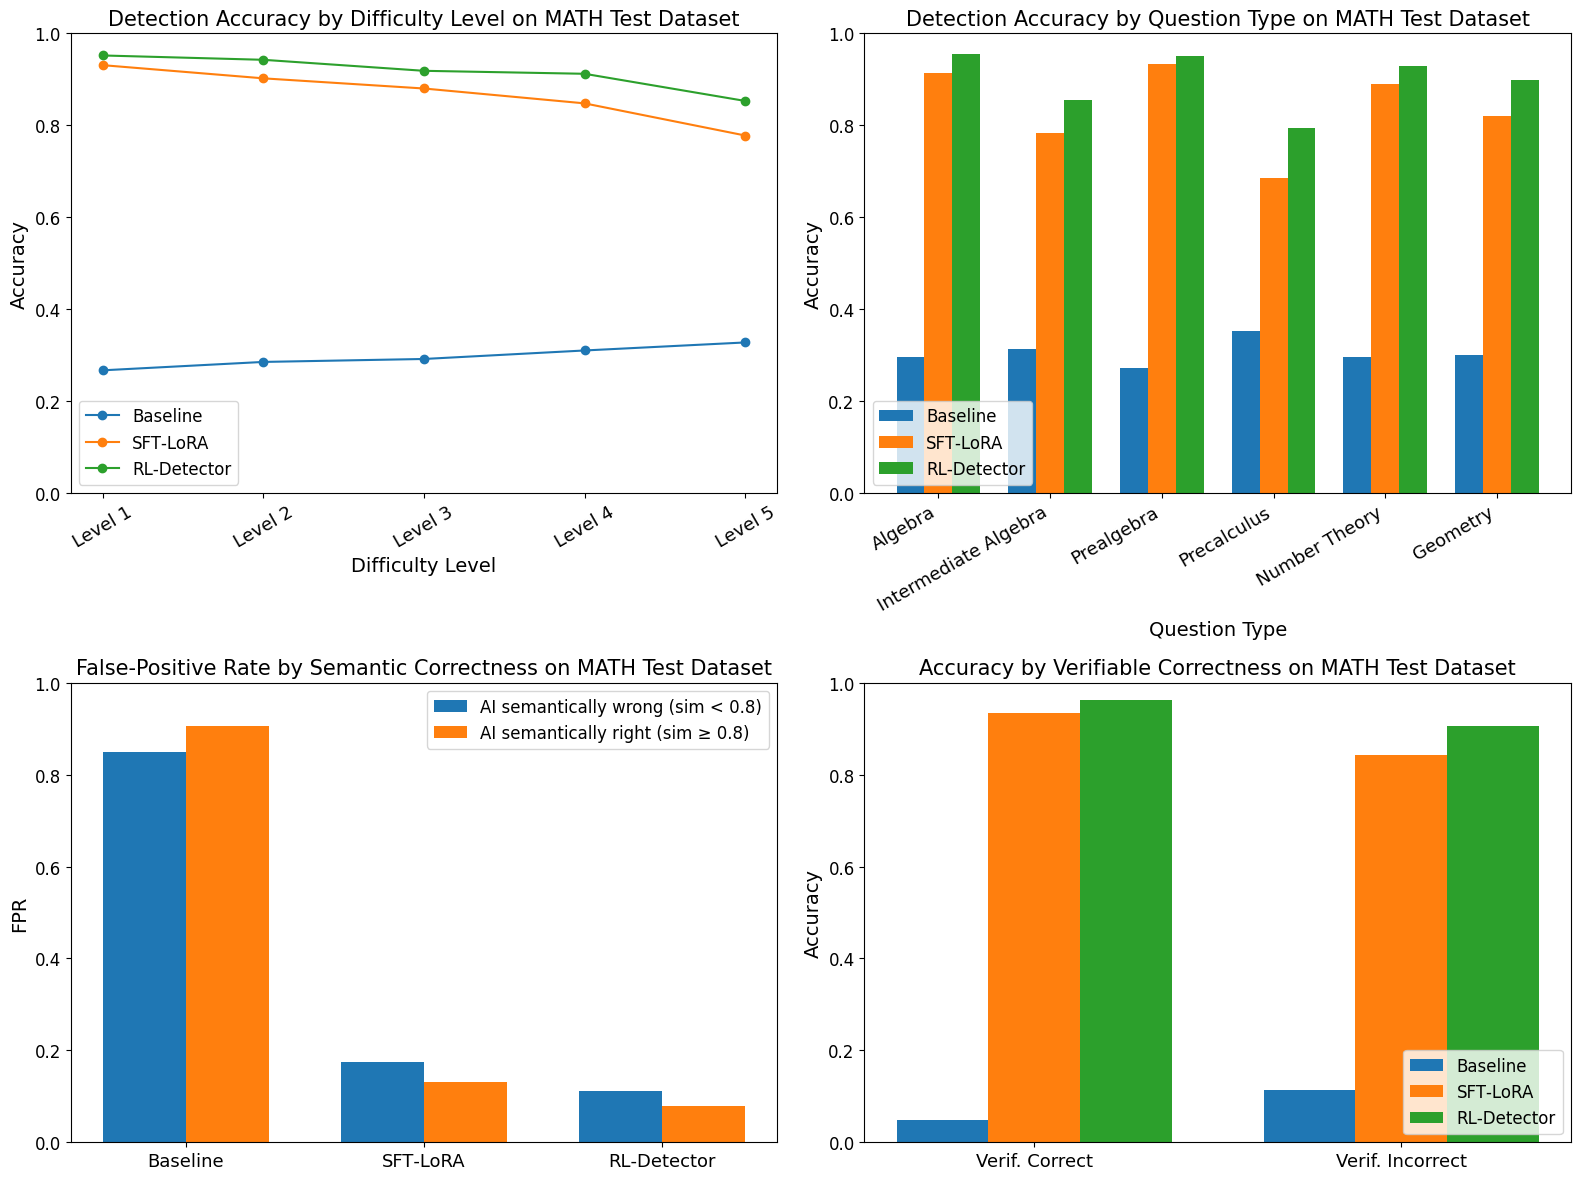

In [ ]:
# Sensitivity panels on MATH dataset
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer
import matplotlib as mpl

# disable TeX, bump font sizes to match paper style
mpl.rcParams['text.usetex'] = False
mpl.rcParams.update({
    'font.size':        13,
    'axes.titlesize':   15,
    'axes.labelsize':   14,
    'xtick.labelsize':  13,
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'figure.titlesize': 18
})

df = test_dfp.copy()

# attach each detector's predictions to df
for model_name, preds in preds_dict.items():
    df[f"pred_{model_name}"] = preds

# extract ground-truth boxed answer for each question
gt_box = (
    df[df["variant"] == "human"][["id", "boxed_answer"]]
      .rename(columns={"boxed_answer": "gt_box"})
)

# merge ground-truth boxes back into full dataframe
results = df.merge(gt_box, on="id", how="left")

# flag verifiable correctness for AI rows
results["verifiable_correct"] = (
    (results["variant"] != "human") &
    (results["boxed_answer"] == results["gt_box"])
)

# prepare 2×2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax_lvl, ax_type), (ax_fpr, ax_verif) = axes

# panel 1: accuracy by difficulty level
levels = sorted(results["level"].unique(), key=lambda s: int(s.split()[-1]))
for name in MODEL_ORDER:
    accs = [
        accuracy_score(
            results[results["level"] == lvl]["label"],
            results[results["level"] == lvl][f"pred_{name}"]
        )
        for lvl in levels
    ]
    ax_lvl.plot(levels, accs, marker="o", label=name)
ax_lvl.set(title="Detection Accuracy by Difficulty Level on MATH Test Dataset",
           xlabel="Difficulty Level", ylabel="Accuracy", ylim=(0,1))
ax_lvl.tick_params(axis="x", rotation=30)
ax_lvl.legend(loc="lower left", frameon=True)

# panel 2: accuracy by question type
top_types = results["type"].value_counts().index[:6]
x = np.arange(len(top_types)); w = 0.25
for i, name in enumerate(MODEL_ORDER):
    accs = [
        accuracy_score(
            results[results["type"] == t]["label"],
            results[results["type"] == t][f"pred_{name}"]
        )
        for t in top_types
    ]
    ax_type.bar(x + i*w, accs, width=w, label=name)
ax_type.set(title="Detection Accuracy by Question Type on MATH Test Dataset",
            xlabel="Question Type", ylabel="Accuracy", ylim=(0,1))
ax_type.set_xticks(x + w)
ax_type.set_xticklabels(top_types, rotation=30, ha="right")
ax_type.legend(loc="lower left", frameon=True)

# panel 3: false-positive rate by semantic correctness
ai_only = results[results["variant"] != "human"].copy()
gt_text = (
    results[results["variant"] == "human"][["id","text"]]
           .rename(columns={"text":"ground_truth"})
)
ai_only = ai_only.merge(gt_text, on="id", how="left")

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

def sem_sim(row):
    e1  = embedder.encode([row["text"]], convert_to_tensor=True)
    e2  = embedder.encode([row["ground_truth"]], convert_to_tensor=True)
    sim = F.cosine_similarity(e1, e2, dim=1).item()
    return (sim + 1) / 2

ai_only["sim"]      = ai_only.apply(sem_sim, axis=1)
ai_only["got_right"] = ai_only["sim"] >= 0.8

x2 = np.arange(len(MODEL_ORDER)); bar_w = 0.35
fpr_w, fpr_r = [], []
for name in MODEL_ORDER:
    col   = f"pred_{name}"
    grp_w = ai_only[~ai_only["got_right"]]
    grp_r = ai_only[ ai_only["got_right"]]
    fpr_w.append((grp_w[col] == 1).mean())
    fpr_r.append((grp_r[col] == 1).mean())

ax_fpr.bar(x2 - bar_w/2, fpr_w, width=bar_w, label="AI sem wrong (sim < 0.8)")
ax_fpr.bar(x2 + bar_w/2, fpr_r, width=bar_w, label="AI sem right (sim ≥ 0.8)")
ax_fpr.set(title="False‐Positive Rate by Semantic Correctness on MATH Test Dataset",
           xticks=x2, xticklabels=MODEL_ORDER, ylim=(0,1), ylabel="FPR")
ax_fpr.legend(loc="upper right", frameon=True)

# panel 4: accuracy by verifiable correctness
ai      = results[results["variant"] != "human"].copy()
labels_vc = ["Verif. Correct", "Verif. Incorrect"]
x3       = np.arange(2)
for i, name in enumerate(MODEL_ORDER):
    accs = [
        accuracy_score(
            ai[ai["verifiable_correct"] == vc]["label"],
            ai[ai["verifiable_correct"] == vc][f"pred_{name}"]
        )
        for vc in [True, False]
    ]
    ax_verif.bar(x3 + i*w, accs, width=w, label=name)

ax_verif.set(title="Accuracy by Verifiable Correctness on MATH Test Dataset",
             xticks=x3 + w, xticklabels=labels_vc, ylim=(0,1), ylabel="Accuracy")
ax_verif.legend(loc="lower right", frameon=True)

plt.tight_layout()
fig.savefig("sensitivity_panels2.png", dpi=300, bbox_inches="tight")


=== Accuracy by Level ===


,Baseline,SFT‑LoRA,RL‑Detector
Level 1,0.267,0.931,0.952
Level 2,0.285,0.902,0.942
Level 3,0.291,0.880,0.918
Level 4,0.310,0.848,0.912
Level 5,0.327,0.778,0.853



=== Accuracy by Type ===


,Baseline,SFT‑LoRA,RL‑Detector
type,,,
Algebra,0.297,0.915,0.955
Intermediate Algebra,0.312,0.784,0.855
Prealgebra,0.271,0.933,0.951
Precalculus,0.351,0.684,0.793
Number Theory,0.295,0.890,0.928
Geometry,0.299,0.821,0.899
Counting & Probability,0.301,0.910,0.944



=== FPR by Semantic ===


,FPR (Wrong),FPR (Right)
Baseline,0.848,0.906
SFT‑LoRA,0.174,0.131
RL‑Detector,0.111,0.079



=== Accuracy by Verif ===


,Baseline,SFT‑LoRA,RL‑Detector
Verif Correct,0.049,0.933,0.961
Verif Incorrect,0.114,0.843,0.906


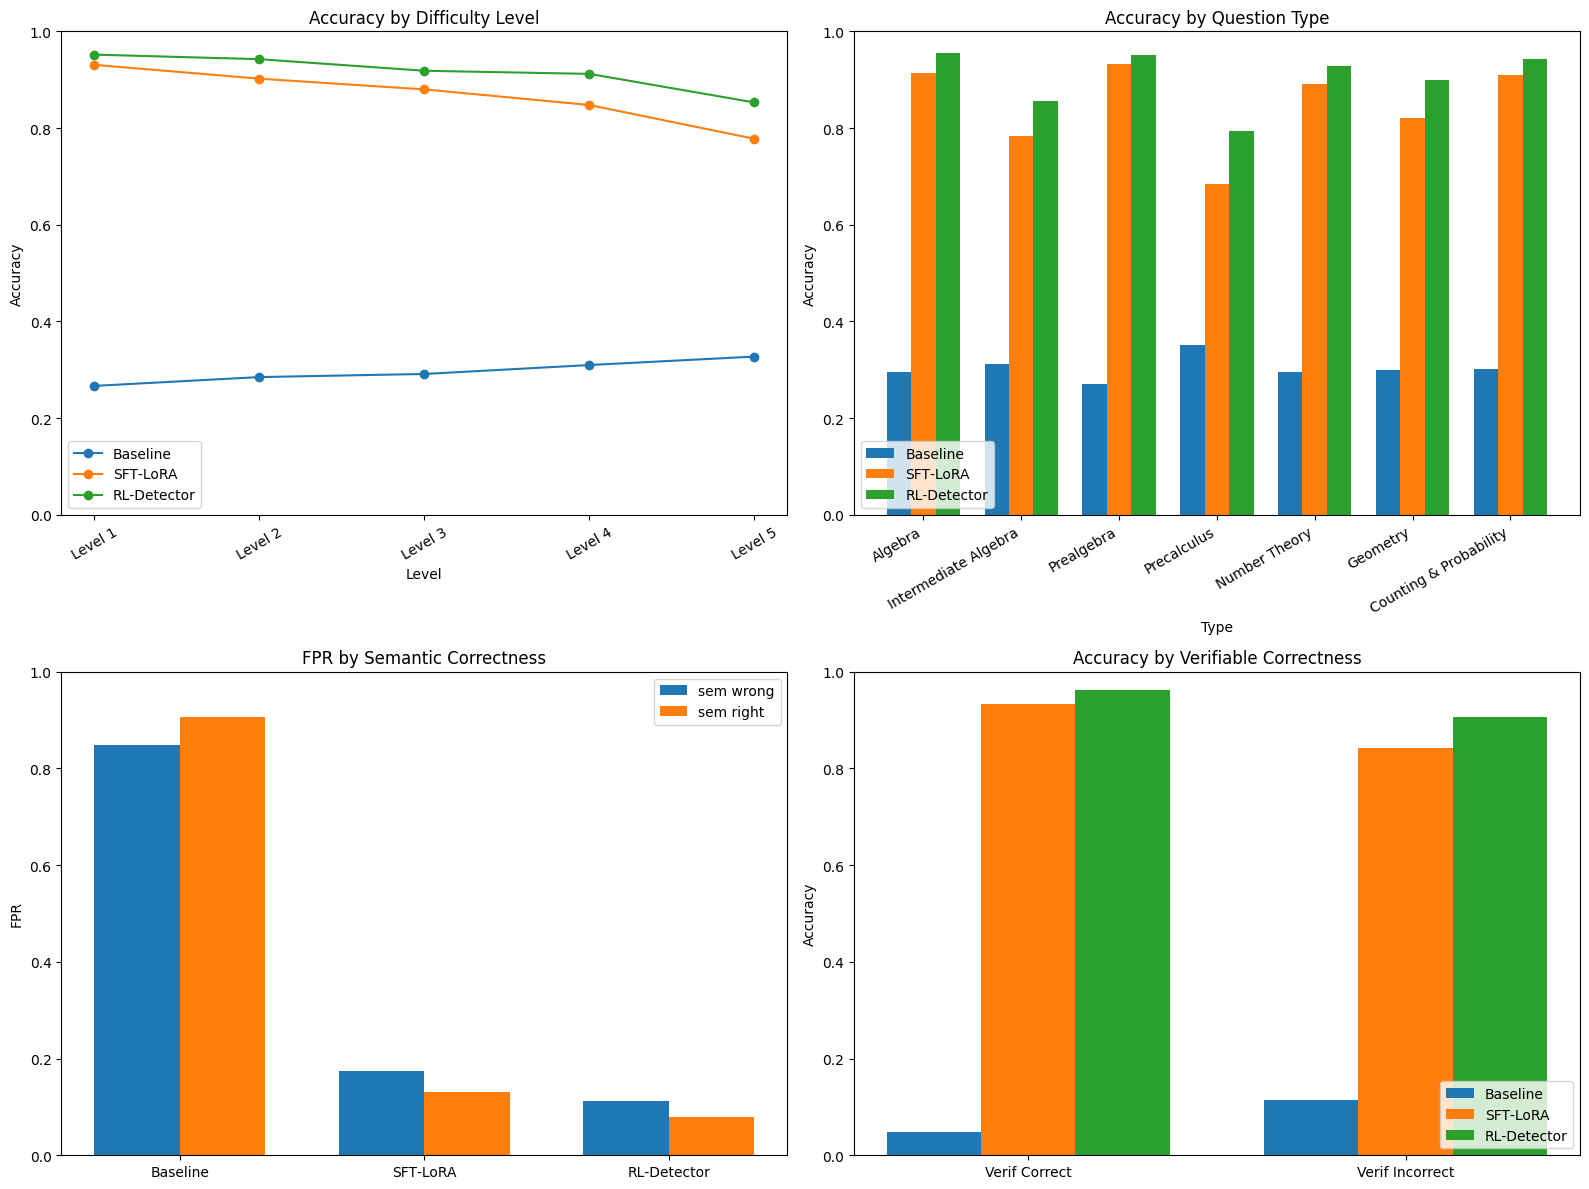

In [ ]:
# Chunk 5: build tables & print
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer
import matplotlib as mpl

# disable TeX again
mpl.rcParams['text.usetex'] = False

df = test_dfp.copy()

# attach predictions for each model
for model_name, preds in preds_dict.items():
    df[f"pred_{model_name}"] = preds

# extract ground-truth boxed answers
gt_box = (
    df[df["variant"] == "human"][["id", "boxed_answer"]]
      .rename(columns={"boxed_answer": "gt_box"})
)

# merge ground-truth into main df
results = df.merge(gt_box, on="id", how="left")

# flag rows where AI answer exactly matches gt box
results["verifiable_correct"] = (
    (results["variant"] != "human")
    & (results["boxed_answer"] == results["gt_box"])
)

# container for result tables
tables = {}

# panel 1: accuracy by difficulty level
levels = sorted(results["level"].unique(), key=lambda s: int(s.split()[-1]))
acc_by_level = {
    name: [
        accuracy_score(
            results[results["level"] == lvl]["label"],
            results[results["level"] == lvl][f"pred_{name}"]
        )
        for lvl in levels
    ]
    for name in MODEL_ORDER
}
df_lvl = pd.DataFrame(acc_by_level, index=levels)
tables["Accuracy by Level"] = df_lvl

# plot panel 1
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax_lvl, ax_type), (ax_fpr, ax_verif) = axes
for name in MODEL_ORDER:
    ax_lvl.plot(levels, df_lvl[name], marker="o", label=name)
ax_lvl.set(title="Accuracy by Difficulty Level",
           xlabel="Level", ylabel="Accuracy", ylim=(0,1))
ax_lvl.tick_params(axis="x", rotation=30)
ax_lvl.legend(loc="lower left")

# panel 2: accuracy by question type
top_types = results["type"].value_counts().index
acc_by_type = {
    name: [
        accuracy_score(
            results[results["type"] == t]["label"],
            results[results["type"] == t][f"pred_{name}"]
        )
        for t in top_types
    ]
    for name in MODEL_ORDER
}
df_type = pd.DataFrame(acc_by_type, index=top_types)
tables["Accuracy by Type"] = df_type

# plot panel 2
x = np.arange(len(top_types)); w = 0.25
for i, name in enumerate(MODEL_ORDER):
    ax_type.bar(x + i*w, df_type[name], width=w, label=name)
ax_type.set(title="Accuracy by Question Type",
            xlabel="Type", ylabel="Accuracy", ylim=(0,1))
ax_type.set_xticks(x + w)
ax_type.set_xticklabels(top_types, rotation=30, ha="right")
ax_type.legend(loc="lower left")

# panel 3: false-positive rate by semantic correctness
ai_only = results[results["variant"] != "human"].copy()
gt_text = (
    results[results["variant"] == "human"][["id","text"]]
           .rename(columns={"text":"ground_truth"})
)
ai_only = ai_only.merge(gt_text, on="id", how="left")

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

def sem_sim(row):
    e1  = embedder.encode([row["text"]], convert_to_tensor=True)
    e2  = embedder.encode([row["ground_truth"]], convert_to_tensor=True)
    return ((F.cosine_similarity(e1, e2, dim=1).item()) + 1) / 2

ai_only["sim"]      = ai_only.apply(sem_sim, axis=1)
ai_only["got_right"] = ai_only["sim"] >= 0.8

fpr_wrong = []
fpr_right = []
for name in MODEL_ORDER:
    col   = f"pred_{name}"
    grp_w = ai_only[~ai_only["got_right"]]
    grp_r = ai_only[ ai_only["got_right"]]
    fpr_wrong.append((grp_w[col] == 1).mean())
    fpr_right.append((grp_r[col] == 1).mean())

df_fpr = pd.DataFrame({
    "FPR (Wrong)": fpr_wrong,
    "FPR (Right)": fpr_right
}, index=MODEL_ORDER)
tables["FPR by Semantic"] = df_fpr

# plot panel 3
x2 = np.arange(len(MODEL_ORDER)); bar_w = 0.35
ax_fpr.bar(x2 - bar_w/2, df_fpr["FPR (Wrong)"], width=bar_w, label="sem wrong")
ax_fpr.bar(x2 + bar_w/2, df_fpr["FPR (Right)"], width=bar_w, label="sem right")
ax_fpr.set(title="FPR by Semantic Correctness", xticks=x2,
           xticklabels=MODEL_ORDER, ylim=(0,1), ylabel="FPR")
ax_fpr.legend(loc="upper right")

# panel 4: accuracy by verifiable correctness
ai      = results[results["variant"] != "human"].copy()
labels_vc = [True, False]
acc_verif = {
    name: [
        accuracy_score(
            ai[ai["verifiable_correct"] == vc]["label"],
            ai[ai["verifiable_correct"] == vc][f"pred_{name}"]
        )
        for vc in labels_vc
    ]
    for name in MODEL_ORDER
}
df_verif = pd.DataFrame(acc_verif, index=["Verif Correct", "Verif Incorrect"])
tables["Accuracy by Verif"] = df_verif

# plot panel 4
x3 = np.arange(2)
for i, name in enumerate(MODEL_ORDER):
    ax_verif.bar(x3 + i*w, df_verif[name], width=w, label=name)
ax_verif.set(title="Accuracy by Verifiable Correctness",
             xticks=x3 + w, xticklabels=df_verif.index,
             ylim=(0,1), ylabel="Accuracy")
ax_verif.legend(loc="lower right")

plt.tight_layout()
fig.savefig("sensitivity_panels.png", dpi=300, bbox_inches="tight")

# finally: print each results table
for title, table in tables.items():
    print(f"\n=== {title} ===")
    display(table.style.format("{:.3f}"))